## 1. Imports

In [20]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import math
import seaborn as sns

 ## 2. EDA 

### 2.1 Import and peek

In [4]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [8]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### 2.2 Missing values analysis

In [22]:
na_sum = train.isna().sum().sum()
na_sum

2324

In [23]:
na_categories = train.isna().sum()
na_categories

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

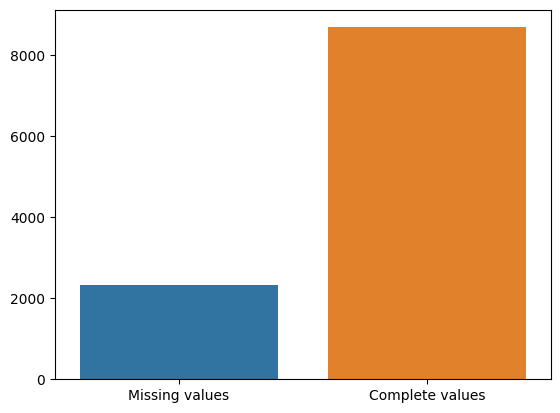

In [73]:
d = {'Missing values': na_sum, 'Complete values':train.shape[0]}
data_info_na = pd.DataFrame(data=d,index=[0])
sns.barplot(data_info_na)
plt.show()

### 2.3 Target variable analysis

In [72]:
target_var_info = train['Transported'].value_counts()
target_var_info

Transported
True     4378
False    4315
Name: count, dtype: int64

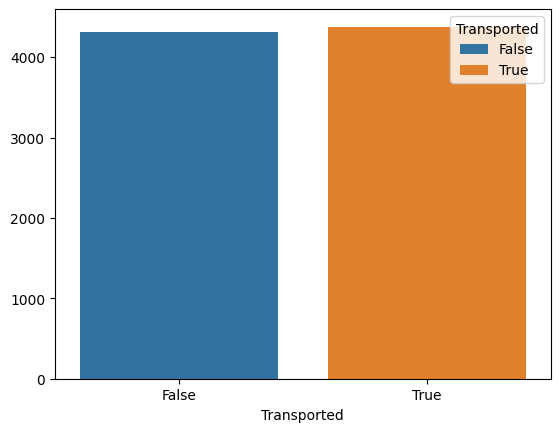

In [75]:
sns.barplot(x=target_var_info.index, y=target_var_info.values, hue=target_var_info.index)
plt.show()

Around 50/50 split for target variable

## 2.4. Specific column analysis

### 2.4.1. Destination

In [96]:
dest = train['Destination'].value_counts()
dest

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

<Axes: xlabel='Destination', ylabel='Count'>

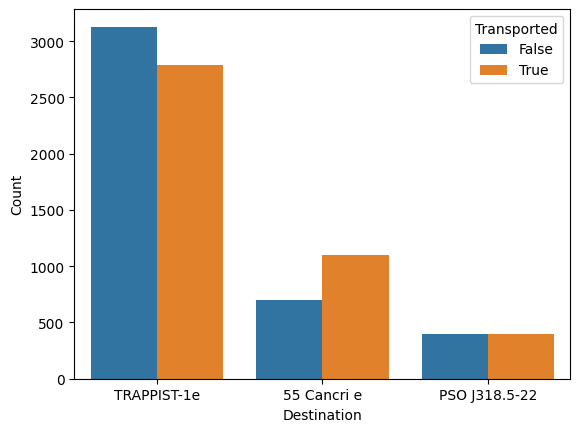

In [110]:
dest_where_false = train['Destination'].where(train['Transported']==False).value_counts()
dest_where_true = train['Destination'].where(train['Transported']==True).value_counts()

dest_data = {'Destination': dest_where_false.index.tolist() + dest_where_true.index.tolist(),
             'Count': dest_where_false.tolist() + dest_where_true.tolist(),
             'Transported':['False']*len(dest_where_false) + ['True']*len(dest_where_true)
             }
dest_data
sns.barplot(x='Destination',y='Count' ,hue='Transported',data=dest_data)

    Conclusions:
1.A little lower prob. of survival by dest. TRAPPIST-1e.\
2.Much higher prob. of survival by dest. Cancri e.\
3.Equal prob. of survival by dest. PSO J318.5-22.

## 3. Dataset

In [33]:
class PassangerDataset(Dataset):
    def __init__(self):

        self.train = pd.read_csv('train.csv', index_col='PassengerId')
        
        X_train = self.train.drop(columns=['Name'])
        X_train[['Cabin_1', 'Cabin_2', 'Cabin_3']] = X_train['Cabin'].str.split('/').apply(pd.Series)
        X_train.drop(columns='Cabin', inplace=True)

        X_train['Cabin_2'] = X_train['Cabin_2'].astype(float)
        for group in range(1,1901,100):
            X_train[f'Cabin_2_{group}-{group+99}'] = (X_train['Cabin_2'] >= group) & (X_train['Cabin_2'] < (group+100))
        
        X_train = X_train.drop(columns='Cabin_2')

        numeric_columns = X_train.select_dtypes(include=['float', 'int'])
        
        X_train.fillna(numeric_columns.mean(), inplace=True)
        X_train.fillna(0.5, inplace=True)

        X_train = pd.get_dummies(X_train, columns=['HomePlanet', 'Destination', 'Cabin_1', 'Cabin_3'])
        self.y = torch.tensor(X_train['Transported'].values)
        
        x_float32 = X_train.drop('Transported', axis=1).values.astype('float32')
        x_not_norm = torch.tensor(x_float32, dtype=torch.float32).view(-1, x_float32.shape[1])

        min_vals = torch.min(x_not_norm, dim=0).values
        max_vals = torch.max(x_not_norm, dim=0).values
        normalized_matrix = (x_not_norm - min_vals) / (max_vals - min_vals)


        self.x = normalized_matrix
    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.train)

## 4. Model

In [88]:
class Nnet(nn.Module):
    def __init__(self, n_input=47):
        super(Nnet, self).__init__()
        
        self.fc_block = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(n_input, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(128, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            
            nn.Dropout(0.5),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.fc_block(x)
        return x



Utility functions

In [9]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()
            labels = labels.view(-1,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

## 5. Neural network training

In [106]:
dataset = PassangerDataset()

total_samples = len(dataset)
train_size = int(0.8 * total_samples)

train_dataset, test_dataset = random_split(dataset, [train_size, total_samples - train_size])

batch_size = 10
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


model = Nnet(47)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)

num_epochs = 30
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0.0

    for i, (inputs, labels) in enumerate(train_dataloader):
        # Forward pass
        
        optimizer.zero_grad()

        y_predicted = model(inputs)
        y = labels.float().view(-1,1)

        loss = loss_function(y_predicted, y)

        loss_history.append(loss.item())

        l2_lambda = 0.001  # Adjust this regularization strength as needed
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        
        loss += l2_lambda * l2_reg

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    average_loss = total_loss / n_iterations
    print(f'Epoch {epoch + 1} - Average Loss: {average_loss:.4f}')

    test_accuracy = calculate_accuracy(model,test_dataloader)
    print(f'Testing Accuracy: {test_accuracy:.2f}%')

print('Training completed.')


Epoch 1 - Average Loss: 0.7646
Testing Accuracy: 69.70%
Epoch 2 - Average Loss: 0.6014
Testing Accuracy: 69.87%
Epoch 3 - Average Loss: 0.5377
Testing Accuracy: 77.23%
Epoch 4 - Average Loss: 0.5016
Testing Accuracy: 78.09%
Epoch 5 - Average Loss: 0.4854
Testing Accuracy: 78.95%
Epoch 6 - Average Loss: 0.4713
Testing Accuracy: 78.78%
Epoch 7 - Average Loss: 0.4623
Testing Accuracy: 78.09%
Epoch 8 - Average Loss: 0.4570
Testing Accuracy: 79.07%
Epoch 9 - Average Loss: 0.4529
Testing Accuracy: 78.78%
Epoch 10 - Average Loss: 0.4480
Testing Accuracy: 79.93%
Epoch 11 - Average Loss: 0.4473
Testing Accuracy: 78.32%
Epoch 12 - Average Loss: 0.4465
Testing Accuracy: 79.59%
Epoch 13 - Average Loss: 0.4459
Testing Accuracy: 80.45%
Epoch 14 - Average Loss: 0.4399
Testing Accuracy: 79.76%
Epoch 15 - Average Loss: 0.4431
Testing Accuracy: 80.05%
Epoch 16 - Average Loss: 0.4410
Testing Accuracy: 80.68%
Epoch 17 - Average Loss: 0.4394
Testing Accuracy: 78.78%
Epoch 18 - Average Loss: 0.4374
Testing 

Test data cleaning

In [95]:
test = pd.read_csv('test.csv')
test_passenger_ids = test['PassengerId']


X_test = test.drop(columns=['Name','PassengerId'])
X_test[['Cabin_1', 'Cabin_2', 'Cabin_3']] = X_test['Cabin'].str.split('/').apply(pd.Series)
X_test.drop(columns='Cabin', inplace=True)

X_test['Cabin_2'] = X_test['Cabin_2'].astype(float)
for group in range(1,1901,100):
    X_test[f'Cabin_2_{group}-{group+99}'] = (X_test['Cabin_2'] >= group) & (X_test['Cabin_2'] < (group+100))
X_test = X_test.drop(columns='Cabin_2')

numeric_columns = X_test.select_dtypes(include=['float', 'int'])
X_test.fillna(numeric_columns.mean(), inplace=True)
X_test.fillna(0.5, inplace=True)

X_test = pd.get_dummies(X_test, columns=['HomePlanet', 'Destination', 'Cabin_1', 'Cabin_3'])
x_float32 = X_test.values.astype('float32')
X_test = torch.tensor(x_float32,dtype=torch.float32,requires_grad=True)


## 6. Submission

In [96]:
import csv

with torch.no_grad():
    predictions = model(X_test)
    predictions = (predictions >= 0.5)
predictions = predictions.squeeze()
predictions = predictions.numpy()
with open('submission.csv','w') as f:
    writer = csv.writer(f)
    header = ['PassengerId','Transported']
    writer.writerow(header)
    f.flush()
    writer.writerows(zip(test_passenger_ids,predictions))
    f.flush()

Loss history

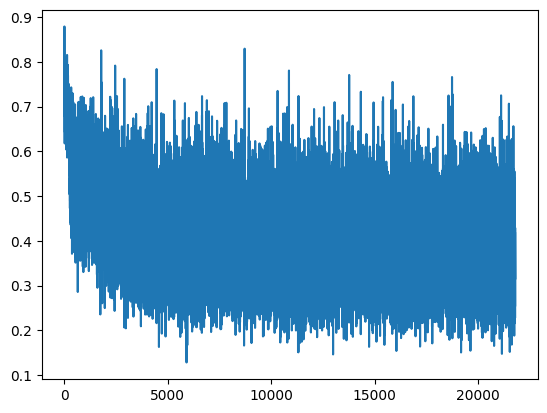

In [98]:
plt.plot(loss_history)